# Project 1: Classify Images of Road Traffic Signs

### Objective
-  Identify and classify images of road traffic signs to enhance navigation systems and improve road safety

### **Dataset**

Source: Belgium Traffic Sign Classification Benchmark, German TSC dataset

Input variables:

Output variable (desired target):

# Table of Contents
* 1. Import Libraries
* 2. Process the dataset
* 3. Exploratory Data Analysis (EDA)
  - 3.1 Visualise sample images according to shape and type
  - 3.2 Data Distribution
* 4. Data Splitting
* 5. Data Modelling
  - 5.1 Baseline Model: MLP NN
    - Model 1.1: Shape classification using MLP NN
    - Model 1.2: Type classification using MLP NN
  - 5.2 Transfer to CNN Model
    - Model 2.1: Shape classification (converting model 1.1 into CNN)
    - Model 2.2: Type classification (converting model 1.2 into CNN)
  - 5.3 Advanced Model: VGG
    - Model 3.1: Shape classification using VGG
    - Model 3.2: Type
classification using CNN
  - Data Augmentation
* 6. Testing the model
* 7. Conclusion
* 8. Reference

## 1. Import Libraries

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import cv2
import tensorflow as tf

# show better graph
%matplotlib inline

In [101]:
from google.colab import drive
drive .mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Connect to the dataset file from google drive

In [102]:
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset.zip .
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset_testing.zip .

# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset.zip .
# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset_testing.zip .

Unzip the dataset

In [103]:
import zipfile
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('trafficsigns_dataset_testing.zip', 'r') as zip_ref_test:
    zip_ref_test.extractall('./')

## 2. Process the dataset
Collect Image Files
- Function to traverse directories recursively and collect image files from the offered dataset and additional dataset for testing

In [104]:
def collect_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

In [105]:
all_image_files = collect_image_files('./trafficsigns_dataset')
all_test_image = collect_image_files('./trafficsigns_dataset_testing')

Create a DataFrame with image file paths in a column named 'image_path'

In [106]:
df = pd.DataFrame({'image_path': all_image_files})
df_test = pd.DataFrame({'image_path': all_test_image})

To encode the traffic sign shapes and types

In [107]:
trafficsigns_shapes = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
trafficsigns_types = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry': 4, 'noparking': 5,
                      'roundabout':6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10,
                      'crossing': 11,  'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

This project involves **multi-class image classification** and features traffic signs categorised into 5 shape classes and 16 type classes, with each image being classified into one of these categories

In [108]:
def assign_class_label(image_path):
    # Split the image path by '/'
    parts = image_path.split('/')

    # Extract shape and type from the parts
    shape = parts[-3]
    trafficsign_type = parts[-2]

    # Map shape and type to corresponding class labels using the dictionaries
    shape_label = trafficsigns_shapes.get(shape, -1)  # -1 if shape not found in dictionary
    type_label = trafficsigns_types.get(trafficsign_type, -1)  # -1 if type not found in dictionary

    # Return a tuple of shape label and type label
    return (shape_label, type_label)


- Get the dataframe with image_path, shape_label and type_label

In [109]:
df['shape_label'], df['type_label'] = zip(*df['image_path'].apply(assign_class_label))
df_test['shape_label'], df_test['type_label'] = zip(*df_test['image_path'].apply(assign_class_label))

In [110]:
print(f"Shape of offered dataset: {df.shape}.\n Shape of additional dataset: {df_test.shape}")

Shape of offered dataset: (3699, 3).
 Shape of additional dataset: (2234, 3)


In [111]:
df.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset/triangle/giveway/01368_...,4,14
1,./trafficsigns_dataset/triangle/giveway/01203_...,4,14
2,./trafficsigns_dataset/triangle/giveway/01829_...,4,14
3,./trafficsigns_dataset/triangle/giveway/00610_...,4,14
4,./trafficsigns_dataset/triangle/giveway/00056_...,4,14


In [112]:
df_test.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset_testing/triangle/givewa...,4,14
1,./trafficsigns_dataset_testing/triangle/givewa...,4,14
2,./trafficsigns_dataset_testing/triangle/givewa...,4,14
3,./trafficsigns_dataset_testing/triangle/givewa...,4,14
4,./trafficsigns_dataset_testing/triangle/givewa...,4,14


## 3. Exploratory Data Analysis (EDA)

## 3.1 Visualise sample images according to shape and type

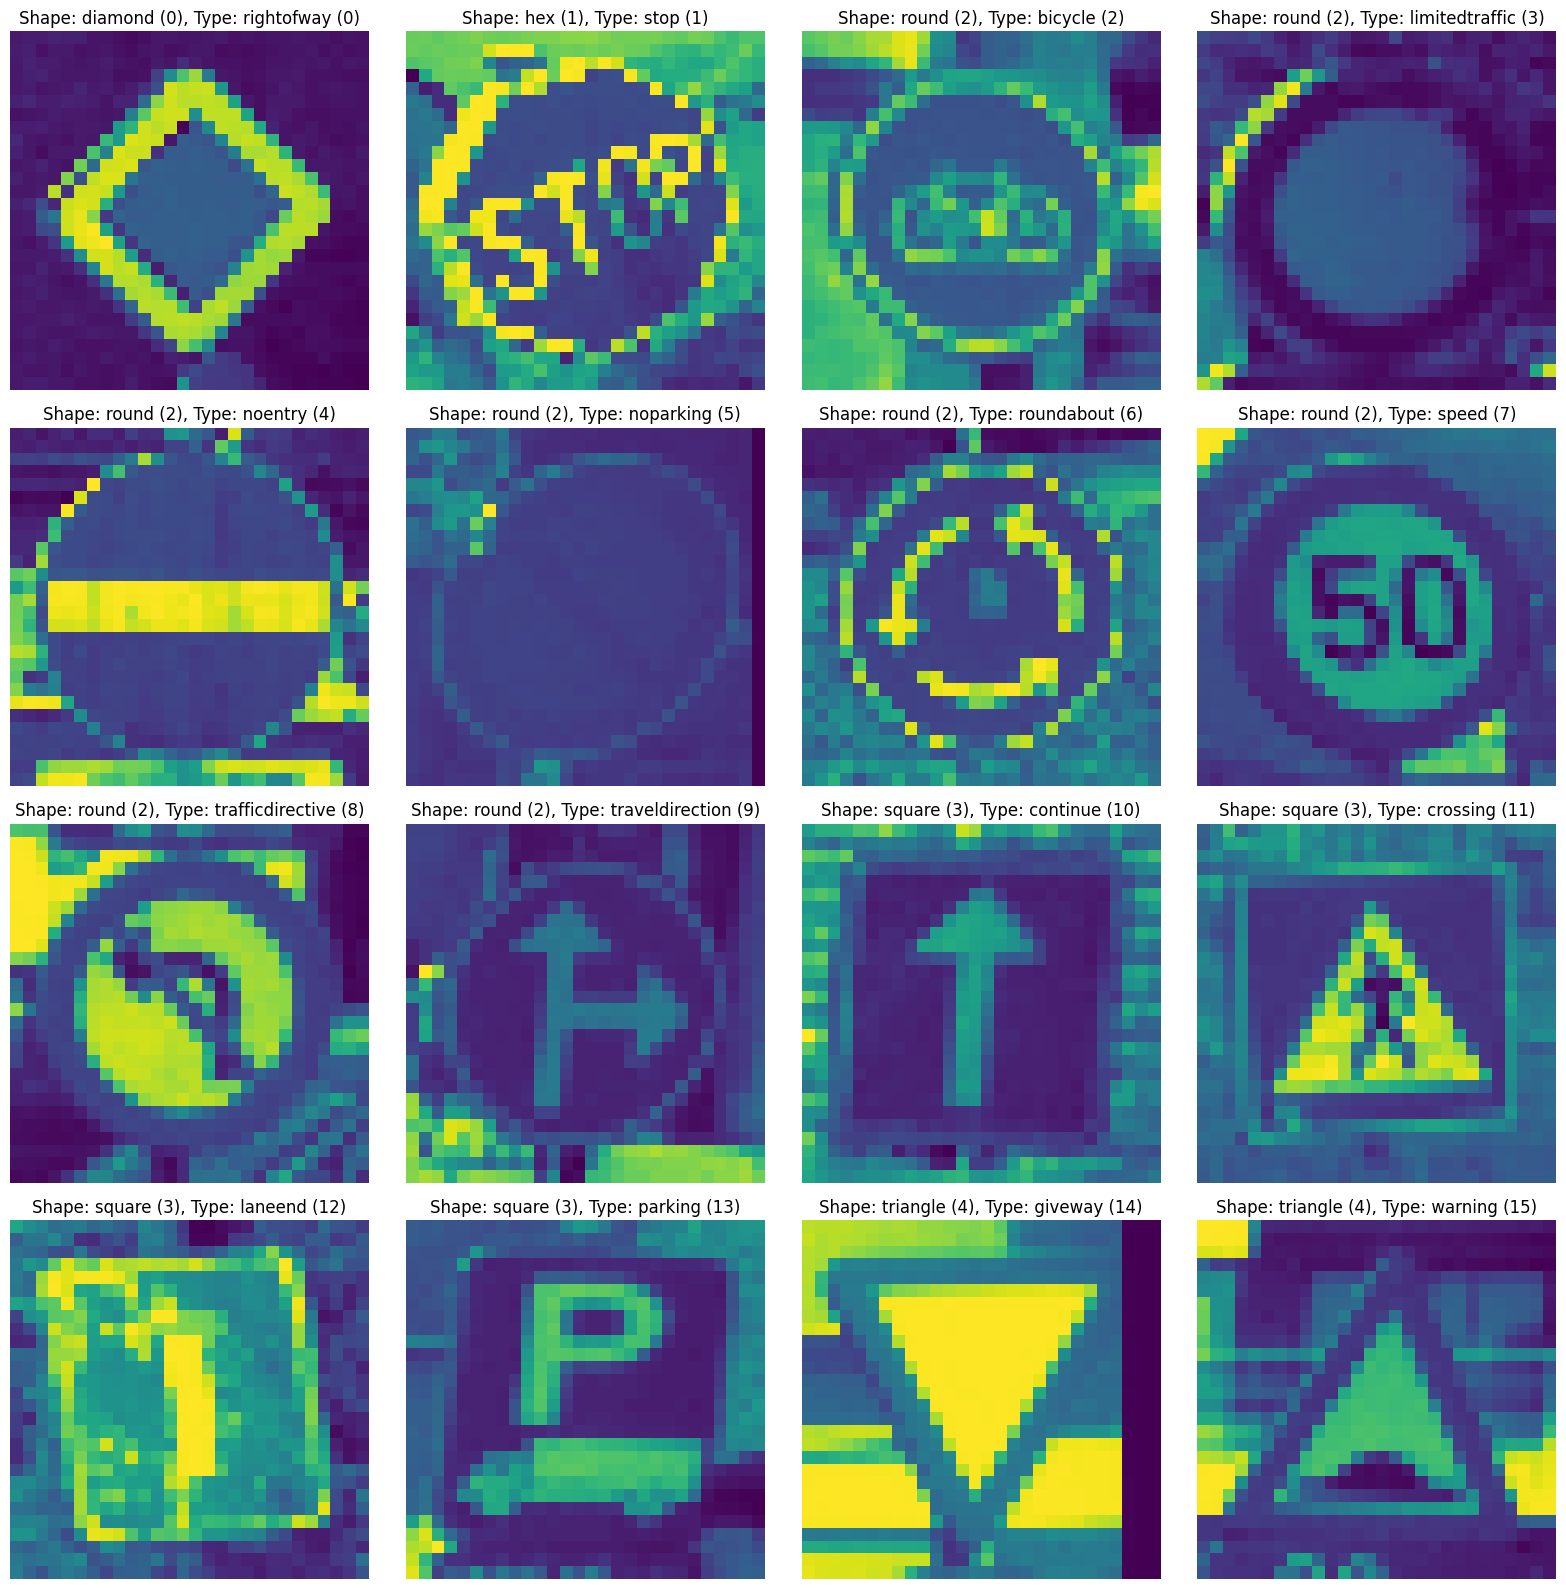

In [113]:
from matplotlib.pyplot import imread
import imageio


df['class_combo'] = df[['shape_label', 'type_label']].apply(tuple, axis=1)

# Reverse dictionaries to map labels back to names
shape_names = {v: k for k, v in trafficsigns_shapes.items()}
type_names = {v: k for k, v in trafficsigns_types.items()}

# Group by this new combo and pick the first image from each group
grouped = df.groupby('class_combo').first().reset_index()

# Visualization
plt.figure(figsize=(16, 16))
for i, row in enumerate(grouped.itertuples(), 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on the number of unique class combinations
    image_path = os.path.join(os.getcwd(), row.image_path)
    image = imread(image_path)
    # Look up the shape and type names using the reverse dictionaries
    shape_name = shape_names.get(row.shape_label, "Unknown")
    type_name = type_names.get(row.type_label, "Unknown")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Shape: {shape_name} ({row.shape_label}), Type: {type_name} ({row.type_label})", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Distribution of the dataset

<ipython-input-114-2dc661fc10c5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
<ipython-input-114-2dc661fc10c5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(type_labels, rotation=45, ha='right')


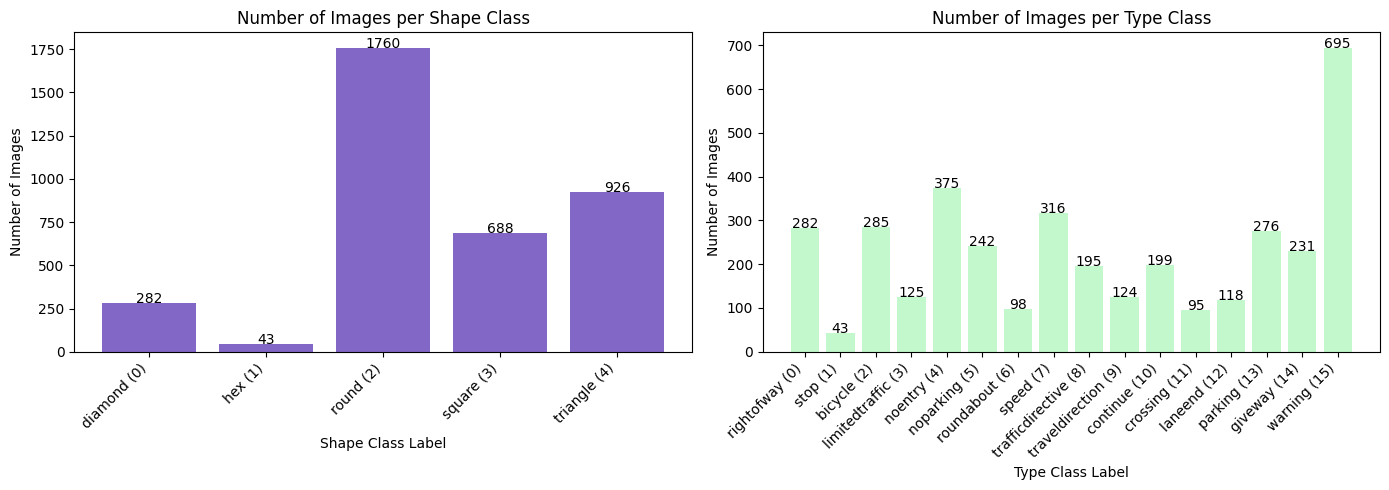

In [114]:
import matplotlib.pyplot as plt


# Convert index to label name for shapes
shape_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_shapes.items(), key=lambda item: item[1])]
# Convert index to label name for types
type_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_types.items(), key=lambda item: item[1])]

# Calculate the count of each class label for shape and type
shape_counts = df['shape_label'].value_counts().sort_index()
type_counts = df['type_label'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Bar chart for shape labels
axes[0].bar(shape_labels, shape_counts.values, color='#8367c7')
axes[0].set_title('Number of Images per Shape Class')
axes[0].set_xlabel('Shape Class Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
for index, value in enumerate(shape_counts.values):
    axes[0].text(index, value, str(value), ha='center')

# Bar chart for type labels
axes[1].bar(type_labels, type_counts.values, color='#C2F8CB')
axes[1].set_title('Number of Images per Type Class')
axes[1].set_xlabel('Type Class Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(type_labels, rotation=45, ha='right')
for index, value in enumerate(type_counts.values):
    axes[1].text(index, value, str(value), ha='center')

plt.tight_layout()
plt.show()



#### Observations:
- Class imbalance: may affect the model performance. Further actions need to be taken to solve it

## 4. Data Spliting
- split offered dataset into 2 parts.
- Training set: 80%
- Validation set: 20%
- Testing set: the additional dataset

**Constants**

In [115]:
# height = 28 pixel, width = 28 pixel, channel = 1 (Grayscale)
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM_SHAPE = 128
HIDDEN_LAYER_DIM_TYPE = 256
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
test_data = df_test

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 2959, Val Data: 740, Test Data: 2234


In [117]:
train_data.shape

(2959, 4)

In [118]:
# Print column names to verify
print(train_data.columns)


Index(['image_path', 'shape_label', 'type_label', 'class_combo'], dtype='object')


## Solve Class Imbalance with Data Augmentation (SMOTE--Oversampling)

Prepare data

#### Define a function to process images

In [119]:
def get_imgs_array(image_paths):
  images_data = []
  # Load all image
  for img_path in image_paths:
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      images_data.append(img)
  return np.array(images_data)

In [120]:
X = get_imgs_array(train_data['image_path'])


shape_labels_encoded = train_data['shape_label'].values
type_labels_encoded = train_data['type_label'].values

# Combine shape and type labels into a single multi-label format
# def tuple_to_formatted_string(tup):
#     return f"{tup[0]}_{tup[1]}"

# combined_labels = np.array(train_data['class_combo'].apply(tuple_to_formatted_string))

X_reshape = X.reshape(X.shape[0], -1)


Initialize SMOTE

In [121]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

Oversampling for shape labels

In [122]:
X_resampled_shape, y_resampled_shape = smote.fit_resample(X_reshape, shape_labels_encoded)
# X_resampled_shape = X_resampled_shape.reshape(X_resampled_shape.shape[0], *original_image_shape)
num_samples = X_resampled_shape.shape[0]
height = 28
width = 28
channel = 1

X_resampled_shape_reshaped = X_resampled_shape.reshape(num_samples, height, width, channel)

In [123]:
def check_oversampling_classes(resampled_label):
  unique_classes_resampled, counts_resampled = np.unique(resampled_label, return_counts=True)
  print("\nOversampled Class Distribution:")
  for cls, count in zip(unique_classes_resampled, counts_resampled):
      print(f"Class {cls}: {count} samples")

check_oversampling_classes(y_resampled_shape)


Oversampled Class Distribution:
Class 0: 1414 samples
Class 1: 1414 samples
Class 2: 1414 samples
Class 3: 1414 samples
Class 4: 1414 samples


Oversampling for shape and type labels

In [124]:
X_resampled_shape_type, y_resampled_type = smote.fit_resample(X_reshape, type_labels_encoded)
print(X_resampled_shape_type.shape)
num_samples = X_resampled_shape_type.shape[0]

X_resampled_shape_type = X_resampled_shape_type.reshape(num_samples, height, width, channel)

(8704, 784)


In [125]:
check_oversampling_classes(y_resampled_type)


Oversampled Class Distribution:
Class 0: 544 samples
Class 1: 544 samples
Class 2: 544 samples
Class 3: 544 samples
Class 4: 544 samples
Class 5: 544 samples
Class 6: 544 samples
Class 7: 544 samples
Class 8: 544 samples
Class 9: 544 samples
Class 10: 544 samples
Class 11: 544 samples
Class 12: 544 samples
Class 13: 544 samples
Class 14: 544 samples
Class 15: 544 samples


## Prepare data for training models

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 64


##### prepare train data generator

In [127]:
# function to create image generator
def create_img_generator(x, y, class_num):
  y = to_categorical(y, num_classes=class_num)
  return datagen.flow(x=x, y=y, batch_size=batch_size)


train_generator_shape = create_img_generator(x=X_resampled_shape_reshaped, y=y_resampled_shape, class_num=OUTPUT_CLASSES_SHAPE)

train_generator_type = create_img_generator(x=X_resampled_shape_type, y=y_resampled_type, class_num=OUTPUT_CLASSES_TYPE)


##### prepare validation data generator

In [128]:
def images_for_flow(image_array):
  num_samples = image_array.shape[0]
  return  image_array.reshape(num_samples, 28, 28, 1)

val_x = get_imgs_array(val_data['image_path'])
val_x = images_for_flow(val_x)
val_y_shape = val_data['shape_label']
val_y_type = val_data['type_label']


validation_generator_shape = create_img_generator(x=val_x, y=val_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

validation_generator_type = create_img_generator(x=val_x, y=val_y_type, class_num=OUTPUT_CLASSES_TYPE)


In [129]:
type(val_y_shape[0])

numpy.int64

#### Define a function to plot accuracy between validation data and train data

In [130]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')


#### Install Keras

To build an image classifier we make use of Tensorflow‘ s Keras API to build our model

In [131]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

#### Set up the layers
We will use the Sequential API to build models as it is the simplest. In a **Sequential** type, each layer takes the output from the previous layer and uses it as its input.
**Dense** layers in a neural network mean that every node in one layer is connected to all the nodes in the previous layer.

In [132]:
!pip install visualkeras

## 5.1 Base Model - MLP Neural Network (for 2 tasks)




* **What is an MLP?**
  - A type of neural network with three or more layers: input, hidden, and output layers.
  - Fully connected: Each neuron in one layer connects to every neuron in the next layer.
  - Utilizes backpropagation for learning, adjusting weights to minimize output error.
* **Why choose an MLP as a baseline model?**
  - Simplicity: Easy to implement and requires less setup time.
  - Efficiency: Quick to train, providing fast initial results.
  - Low Resource Use: Less computationally intensive than more complex models.
  - Performance Benchmarking: Provides a reference point for evaluating more advanced models.
  - Data Requirements: Performs well with smaller datasets, ideal when large data is unavailable.
  - Interpretability: Simple architecture makes it easier to understand and deb

### **Model1.1 Baseline Model --- Traffic sign shape**

In [133]:
model_shape_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_SHAPE, activation='relu', name='m1_shape_hidden1'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_shape_hidden2'),
    tf.keras.layers.Dense(units=16, activation='relu', name='m1_shape_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_SHAPE, activation='softmax', name='m1_shape_output')
])

model_shape_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])

In [134]:
model_shape_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 m1_shape_hidden1 (Dense)    (None, 128)               100480    
                                                                 
 m1_shape_hidden2 (Dense)    (None, 64)                8256      
                                                                 
 m1_shape_hidden3 (Dense)    (None, 16)                1040      
                                                                 
 m1_shape_output (Dense)     (None, 5)                 85        
                                                                 
Total params: 109861 (429.14 KB)
Trainable params: 109861 (429.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


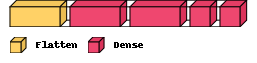

In [135]:
import visualkeras
# Generating the image for model architecture
visualkeras.layered_view(model_shape_1, scale_xy=2, scale_z=1, max_z=50, legend=True)


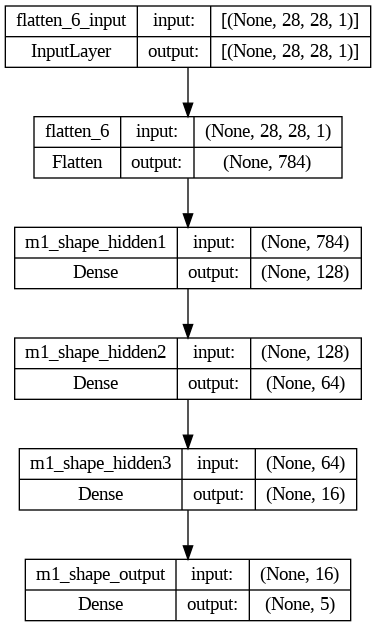

In [136]:
tf.keras.utils.plot_model(model_shape_1, show_shapes=True)


#### Train the base model for shape


train the base model for shape

In [137]:
history_1_shape = model_shape_1.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=50, verbose=0)

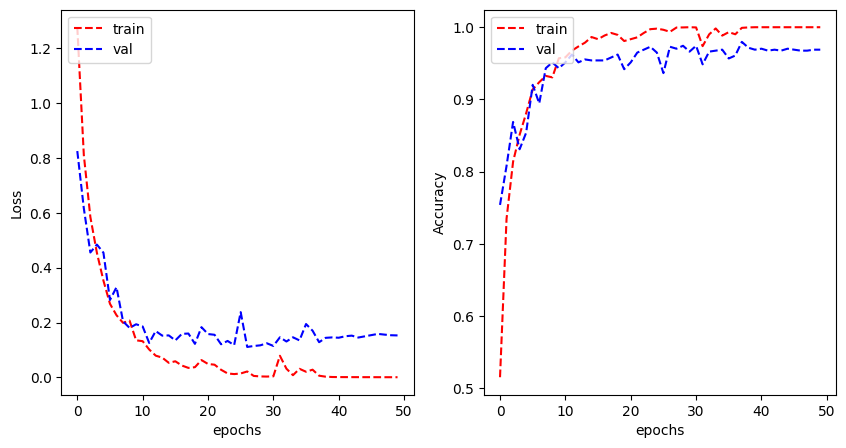

In [138]:
plot_learning_curve(history_1_shape.history['loss'], history_1_shape.history['val_loss'],
                    history_1_shape.history['categorical_accuracy'], history_1_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

#### Function to plot **Confusion Matrix** (Will apply this function with final test)

In [139]:
def plot_confusion_matrix(model, x_set, y_set, nr_classes, label_names):

  predictions = np.argmax(model.predict(x_set / 255.0), axis=1)
  f1score = f1_score(y_set, predictions, average='weighted')
  print(f"F1 Score: {f1score:.2f}")
  accuracy = np.mean(predictions == y_set) * 100
  print(f"Accuracy: {accuracy:.2f}%")
  conf_matrix = confusion_matrix(y_set, predictions)

  nr_rows = conf_matrix.shape[0]
  nr_cols = conf_matrix.shape[1]
  plt.figure(figsize=(7,7), dpi=150)
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)

  plt.title('Confusion Matrix', fontsize=16)
  plt.ylabel('Actual Labels', fontsize=12)
  plt.xlabel('Predicted Labels', fontsize=12)

  tick_marks = np.arange(nr_classes)
  plt.yticks(tick_marks, label_names)
  plt.xticks(tick_marks, label_names, rotation=45, ha='right')

  plt.colorbar()

  for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

  plt.show()


### use test data plot confusion matrix

In [140]:
test_x = get_imgs_array(test_data['image_path'])
test_x = images_for_flow(test_x)
test_y_shape = test_data['shape_label']
test_y_type = test_data['type_label']


test_generator_shape = create_img_generator(x=test_x, y=test_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

test_generator_type = create_img_generator(x=test_x, y=test_y_type, class_num=OUTPUT_CLASSES_TYPE)


#### Here is to test the plot_confusion_matrix function (Will delete)

In [141]:
model_shape_1.evaluate(test_generator_shape)

35/35 [==============================] - 0s 5ms/step - loss: 0.1124 - categorical_accuracy: 0.9767


[0.11238225549459457, 0.9767233729362488]

70/70 [==============================] - 0s 2ms/step
F1 Score: 0.98
Accuracy: 97.67%


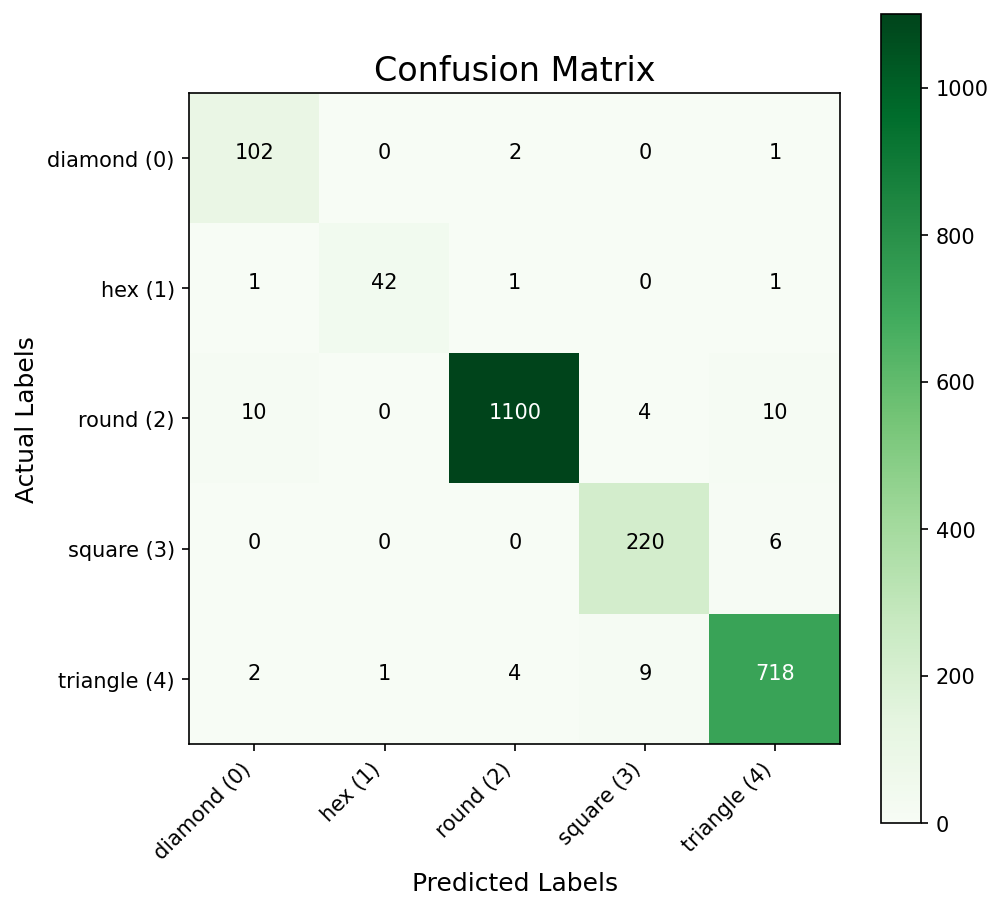

In [142]:
plot_confusion_matrix(model_shape_1, test_x, test_y_shape, OUTPUT_CLASSES_SHAPE, shape_labels)

### **Model1.2 Baseline Model --- traffic sign type**

In [143]:
model_type_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_TYPE, activation='relu', name='m1_type_hidden1'),
    tf.keras.layers.Dense(units=128, activation='relu', name='m1_type_hidden2'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_type_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_TYPE, activation='softmax', name='m1_output')
])

model_type_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])

In [144]:
model_type_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 m1_type_hidden1 (Dense)     (None, 256)               200960    
                                                                 
 m1_type_hidden2 (Dense)     (None, 128)               32896     
                                                                 
 m1_type_hidden3 (Dense)     (None, 64)                8256      
                                                                 
 m1_output (Dense)           (None, 16)                1040      
                                                                 
Total params: 243152 (949.81 KB)
Trainable params: 243152 (949.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


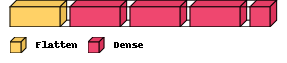

In [145]:
# Generating the image for model architecture
visualkeras.layered_view(model_type_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

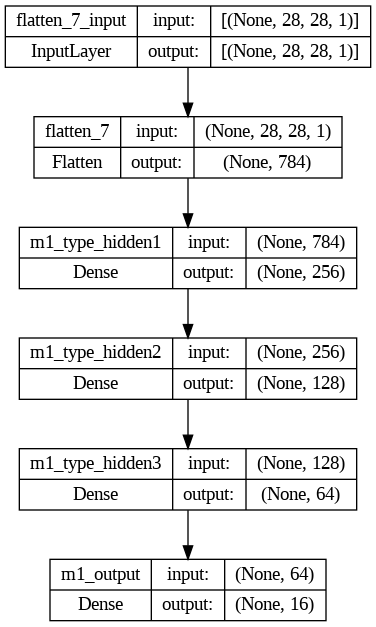

In [146]:
tf.keras.utils.plot_model(model_type_1, show_shapes=True)

### train the base model (type)

In [147]:
# %%time
history_1_type = model_type_1.fit(train_generator_type, validation_data = validation_generator_type, epochs=50, verbose=0)

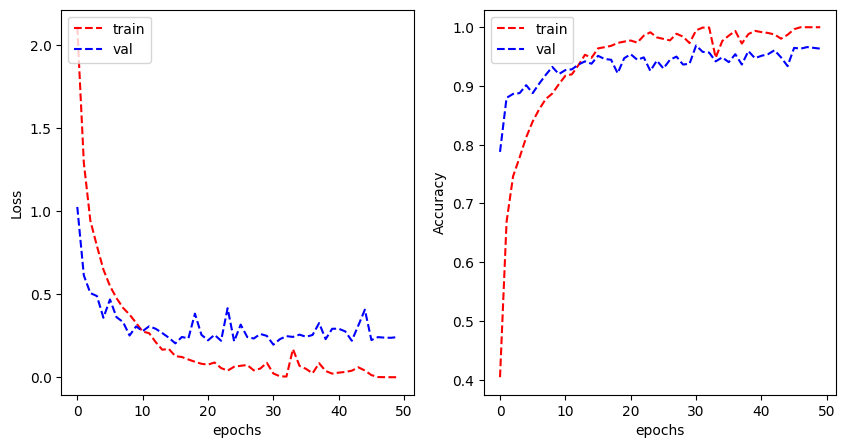

In [148]:
plot_learning_curve(history_1_type.history['loss'], history_1_type.history['val_loss'],
                    history_1_type.history['categorical_accuracy'], history_1_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [199]:
model_type_1.evaluate(test_generator_type)

35/35 [==============================] - 1s 10ms/step - loss: 0.2385 - categorical_accuracy: 0.9593


[0.23852087557315826, 0.9592658877372742]

Observations:



# Model 2 Transfer to CNN model
- replacing the Flatten layer with convolutional (Conv2D) and pooling (MaxPooling2D) layers.

#### 1. model to classify shape


In [149]:
model_shape_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM, name='conv1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(64, activation='relu', name='dense1'),
    tf.keras.layers.Dense(16, activation='relu', name='dense2'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax', name='output')
])

model_shape_2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])


In [150]:
model_shape_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense1 (Dense)              (None, 64)              

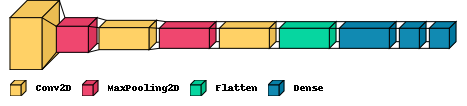

In [151]:
visualkeras.layered_view(model_shape_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

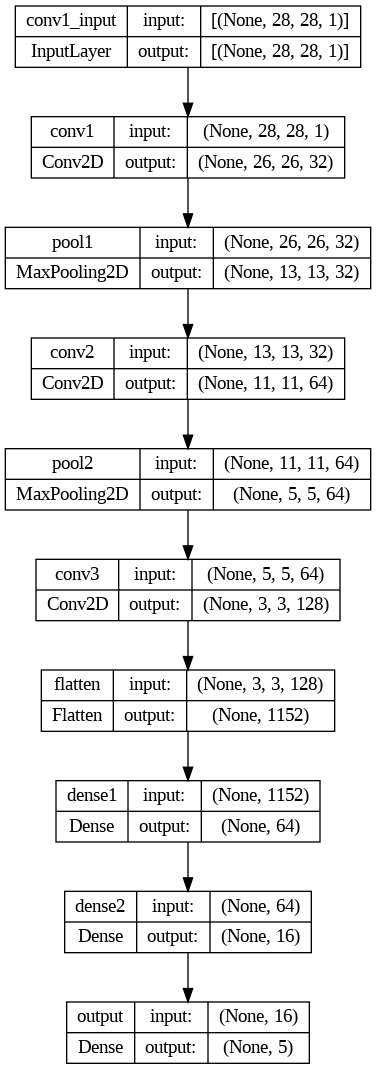

In [152]:
tf.keras.utils.plot_model(model_shape_2, show_shapes=True)

### Fit the model

In [153]:
history_2_shape = model_shape_2.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=50, verbose=0)

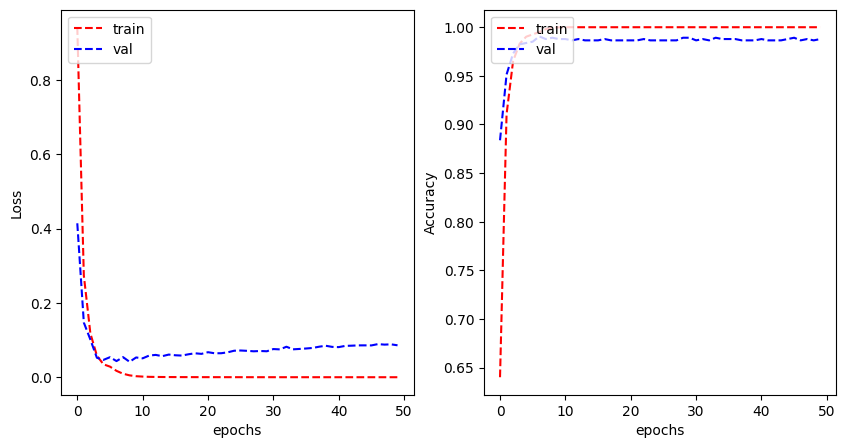

In [154]:
plot_learning_curve(history_2_shape.history['loss'], history_2_shape.history['val_loss'],
                    history_2_shape.history['categorical_accuracy'], history_2_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [155]:
model_shape_2.evaluate(test_generator_shape)

35/35 [==============================] - 0s 7ms/step - loss: 0.0389 - categorical_accuracy: 0.9942


[0.038911011070013046, 0.9941808581352234]

#### 2. model to classify types

In [157]:
model_type_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM, name='conv1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(128, activation='relu', name='dense1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense2'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax', name='output')
])

model_type_2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])

In [158]:
model_type_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense1 (Dense)              (None, 128)             

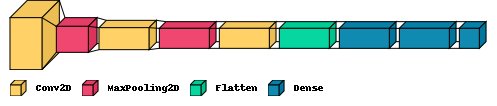

In [159]:
visualkeras.layered_view(model_type_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

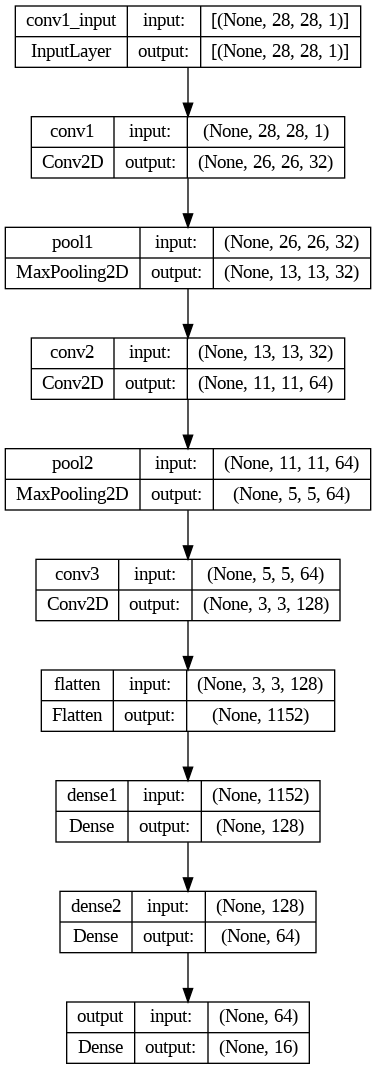

In [160]:
tf.keras.utils.plot_model(model_type_2, show_shapes=True)

##### fit the model

In [161]:
history_2_type = model_type_2.fit(train_generator_type, validation_data = validation_generator_type, epochs=50, verbose=0)

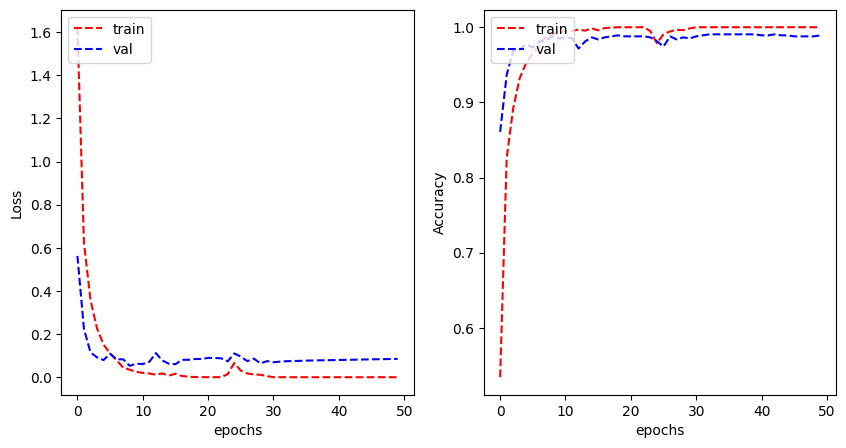

In [162]:
plot_learning_curve(history_2_type.history['loss'], history_2_type.history['val_loss'],
                    history_2_type.history['categorical_accuracy'], history_2_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [202]:
model_type_2.evaluate(test_generator_type)

35/35 [==============================] - 0s 8ms/step - loss: 0.1889 - categorical_accuracy: 0.9834


[0.18887260556221008, 0.9834377765655518]

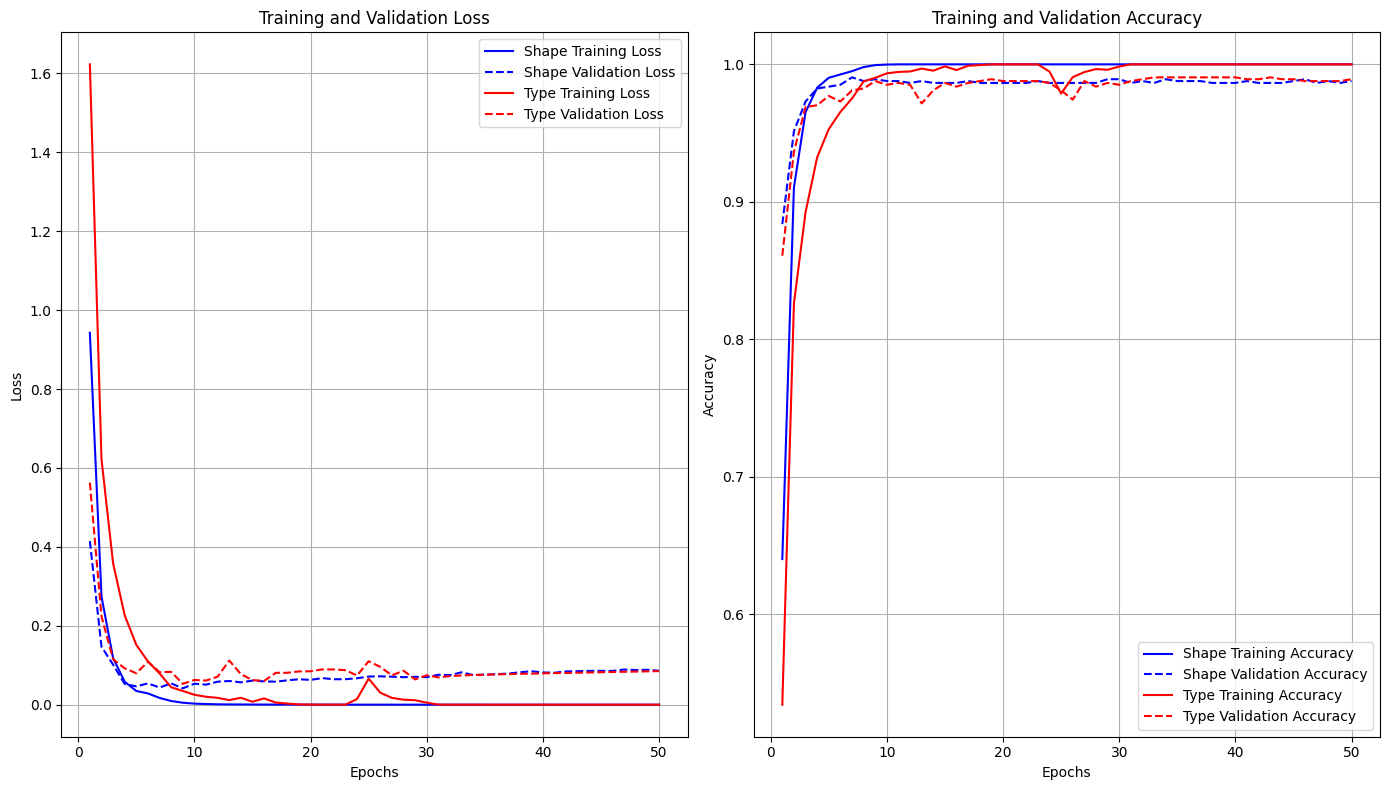

In [164]:
import matplotlib.pyplot as plt

def plot_combined_learning_curve(shape_history, type_history, metric_name='Accuracy'):
    epochs = range(1, len(shape_history['loss']) + 1)

    plt.figure(figsize=(14, 8))

    # Plot training and validation loss for shape and type
    plt.subplot(1, 2, 1)
    plt.plot(epochs, shape_history['loss'], 'b-', label='Shape Training Loss')
    plt.plot(epochs, shape_history['val_loss'], 'b--', label='Shape Validation Loss')
    plt.plot(epochs, type_history['loss'], 'r-', label='Type Training Loss')
    plt.plot(epochs, type_history['val_loss'], 'r--', label='Type Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy for shape and type
    plt.subplot(1, 2, 2)
    plt.plot(epochs, shape_history['categorical_accuracy'], 'b-', label='Shape Training Accuracy')
    plt.plot(epochs, shape_history['val_categorical_accuracy'], 'b--', label='Shape Validation Accuracy')
    plt.plot(epochs, type_history['categorical_accuracy'], 'r-', label='Type Training Accuracy')
    plt.plot(epochs, type_history['val_categorical_accuracy'], 'r--', label='Type Validation Accuracy')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming history_2_shape and history_2_type are available
plot_combined_learning_curve(history_2_shape.history, history_2_type.history, metric_name='Accuracy')


# 5.2 Advanced Model: CNN model


CNNs are better suited for tasks like image recognition because they can exploit the spatial structure of the data through convolutional layers, reducing the number of parameters needed compared to fully connected layers in MLPs, making them more efficient and effective for tasks with spatial relationships, like images.



# VGG

The VGG architecture enhances basic CNNs through:
1. Uniformity: It consistently uses 3×3 convolutional filters and 2×2 max pooling, facilitating deeper network construction.
2. Depth: Deeper layers in VGG allow for more complex feature learning, improving image classification performance.
3. Robust Training: Strong initialisation, regularisation, and augmentation strategies improve training and prevent overfitting.



Observations:


Visually Interpreting the CNN's Inner Layers

We examine the internal layers of the CNN model to gain insights and interpret the significance of the features that the model identified while classifying a traffic sign

### Model 2.1 Shape classification using VGG CNN


In [165]:
model_VGG_1 = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'),
])

In [166]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [167]:
model_VGG_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                               

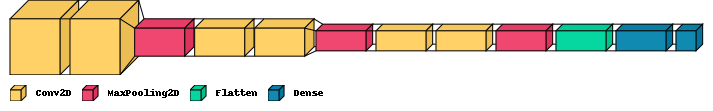

In [168]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

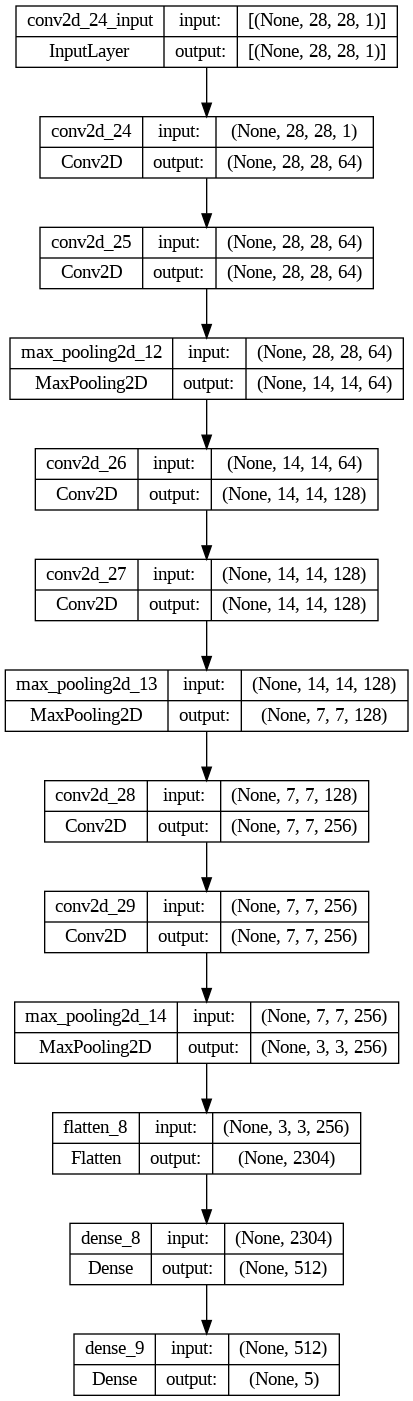

In [169]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

Fit the model

In [170]:
history_VGG_1 = model_VGG_1.fit(
    train_generator_shape,
    validation_data=validation_generator_shape,
    epochs=50,
    verbose=0
)

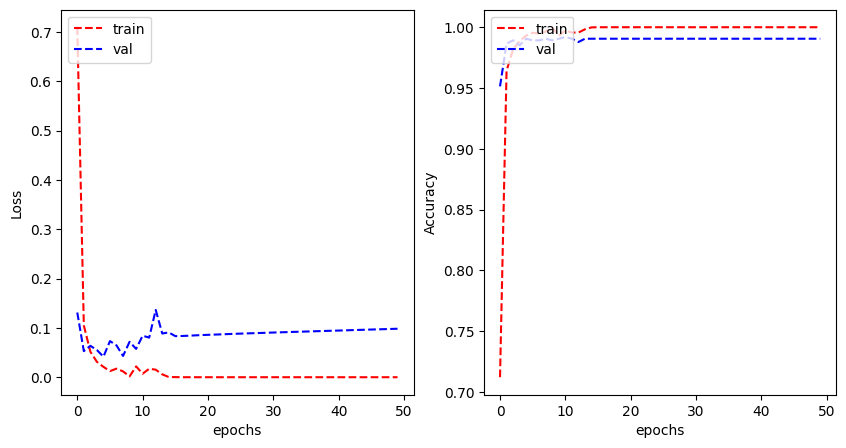

In [171]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [172]:
model_VGG_1.evaluate(test_generator_shape)

35/35 [==============================] - 0s 5ms/step - loss: 0.0595 - categorical_accuracy: 0.9924


[0.059455398470163345, 0.9923903346061707]

### Add Normalisation and Dropout layers


Justification for Adding Batch Normalization and Dropout:
* Batch Normalization: Stabilizes and accelerates training, allows higher learning rates, and reduces sensitivity to weight initialization.
* Dropout: Prevents overfitting and improves generalization by randomly setting a fraction of input units to zero during training.

These additions enhance model stability, speed, and performance on unseen data.

In [174]:
# Improved VGG-like CNN model for shape classification
model_VGG_1_improved = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'),
])

In [175]:
model_VGG_1_improved.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [176]:
model_VGG_1_improved.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_8 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 128)     

Fit the model

In [177]:
history_VGG_1_improved = model_VGG_1_improved.fit(
    train_generator_shape,
    validation_data=validation_generator_shape,
    epochs=50,
    verbose=0
)

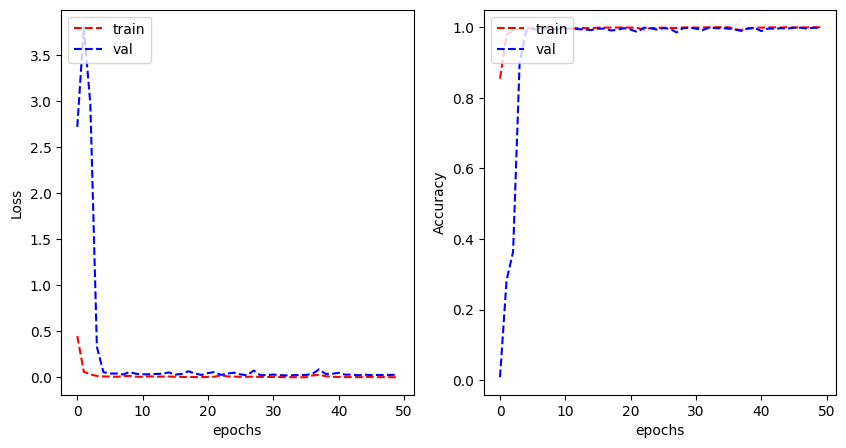

In [178]:
plot_learning_curve(history_VGG_1_improved.history['loss'], history_VGG_1_improved.history['val_loss'],
                    history_VGG_1_improved.history['categorical_accuracy'], history_VGG_1_improved.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [179]:
model_VGG_1_improved.evaluate(test_generator_shape)

35/35 [==============================] - 0s 7ms/step - loss: 0.0179 - categorical_accuracy: 0.9969


[0.017882317304611206, 0.9968665838241577]

### Model 2.2 Type classification using VGG CNN


In [180]:
model_VGG_2 = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax'),
])

In [181]:
model_VGG_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                               

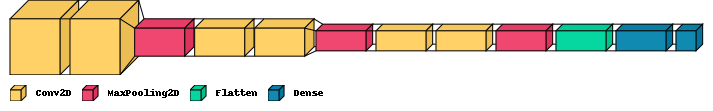

In [182]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

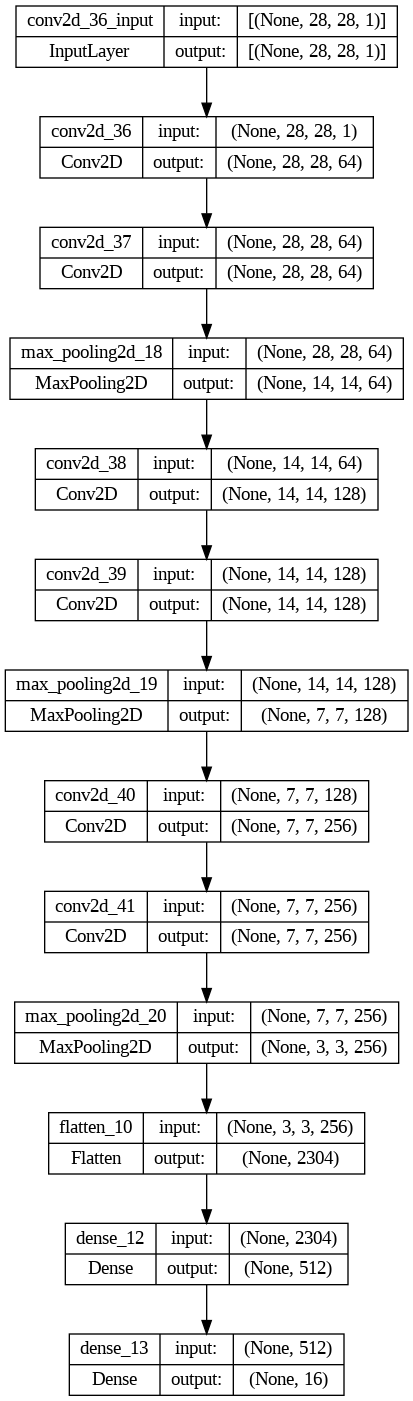

In [183]:
tf.keras.utils.plot_model(model_VGG_2, show_shapes=True)

In [184]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [185]:
history_VGG_2 = model_VGG_2.fit(
    train_generator_type,
    validation_data=validation_generator_type,
    epochs=50,
    verbose=0
)

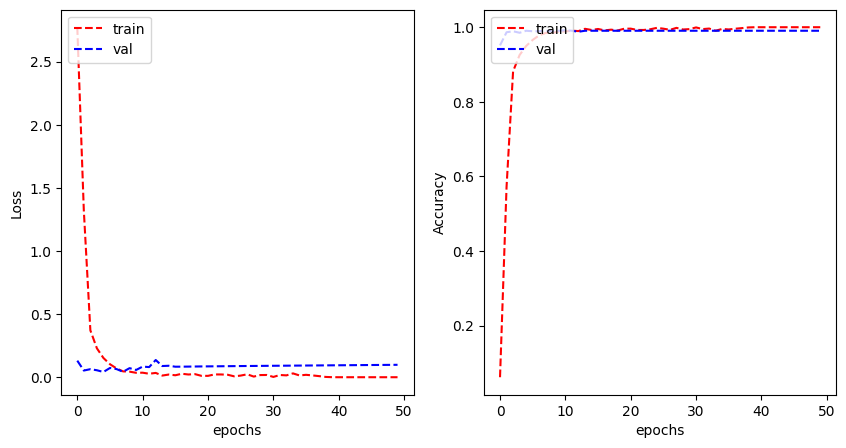

In [186]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_2.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [187]:
model_VGG_2.evaluate(test_generator_type)

35/35 [==============================] - 0s 5ms/step - loss: 0.3342 - categorical_accuracy: 0.9799


[0.33424893021583557, 0.9798567295074463]

### Add Normalisation and Dropout layers

In [189]:
# Improved VGG-like CNN model for shape classification
model_VGG_2_improved = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax'),
])

In [190]:
model_VGG_2_improved.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [191]:
model_VGG_2_improved.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 128)     

Fit the model

In [192]:
history_VGG_2_improved = model_VGG_2_improved.fit(
    train_generator_type,
    validation_data=validation_generator_type,
    epochs=50,
    verbose=0
)

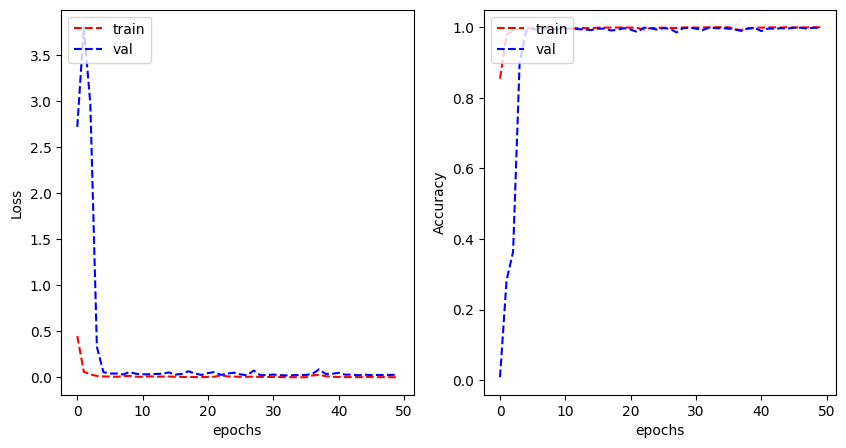

In [193]:
plot_learning_curve(history_VGG_1_improved.history['loss'], history_VGG_1_improved.history['val_loss'],
                    history_VGG_1_improved.history['categorical_accuracy'], history_VGG_1_improved.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [194]:
model_VGG_2_improved.evaluate(test_generator_type)

35/35 [==============================] - 0s 6ms/step - loss: 0.0764 - categorical_accuracy: 0.9848


[0.07643382996320724, 0.9847806692123413]

## 6. Testing the final model

Display prediction result

show green color when correct & red when incorrect Actual Vs Predicted

In [195]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 1

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(32, 32),
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

In [196]:
# # Data generator for test data
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# batch_size = 32  # or any batch size that fits your memory constraints

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='./',
#         x_col="image_path",
#         y_col=["Shape", "Type"],  # Assuming you want to predict both Shape and Type
#         target_size=(28, 28),  # Ensure target size matches the input size of the network
#         batch_size=batch_size,
#         class_mode='multi_output')  # Set to 'multi_output' to match your model's configuration

# # Evaluate the model
# final_model.evaluate(test_generator)


In [197]:
# ## still wrong

# import matplotlib.pyplot as plt
# import numpy as np

# # Increase the figure size and font size for better visibility
# plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 12}  # Increase font size for better readability
# plt.rc('font', **font)

# batches = 0
# for x, y in test_generator:
#     batches += 1
#     y_hat = final_model.predict(x, verbose=0)
#     x = np.squeeze(x)
#     if batches < 5:
#         plt.subplot(1, 5, batches)
#         plt.imshow(x[0])  # Displaying the first image in the batch
#         shape_pred_index = np.argmax(y[0])
#         type_pred_index = np.argmax(y_hat[1])
#         try:
#             shape_label = shapes_inv[shape_pred_index]
#         except KeyError:
#             shape_label = 'Unknown Shape'
#         try:
#             type_label = types_inv[type_pred_index]
#         except KeyError:
#             type_label = 'Unknown Type'
#         plt.title("Actual-{}, Pred-{}".format(shape_label, type_label), pad=20)  # Add padding to avoid overlap
#     else:
#         break

#     plt.axis('off')
# plt.tight_layout()  # Adjust layout to fit everything nicely
# plt.show()


## 7. Conclusion


MLPs serve as a practical baseline for tasks like traffic sign classification due to their straightforward implementation and quick training. They are capable of modelling interactions between all input features, which is crucial for recognising complex patterns in the dataset. However, they are typically less effective than Convolutional Neural Networks (CNNs) for processing image data, as CNNs excel at capturing spatial hierarchies through their convolutional layers. This is evident from comparison tables where CNNs consistently show lower loss and higher accuracy.
In conclusion, we think Model 2 (CNN) is superior.


# 8. References

- https://www.linkedin.com/pulse/classify-traffic-signs-deep-learning-james-medel/
- https://github.com/james94/P3-Traffic-Sign-Classifier-CarND/blob/master/Traffic_Sign_Classifier_with_LeNet.ipynb
- https://www.youtube.com/watch?v=jztwpsIzEGc
- https://www.datacamp.com/tutorial/cnn-tensorflow-python